## CODE FOR CALCULATING FUTURE DIC USING C* METHOD

#### GUIDING QUESTION: USING AN ESTIMATE OF AGES FROM CFC OSERVATIONS IN THE 2020 COASTAL GLODAP DATASET AND THE GRUBER C* METHOD, WHEN CAN WE EXPECT THE [TA-DIC]<50 THRESHOLD TO BE CROSSED IN THE COASTAL OCEAN? 

#### CORRESPONDING SCRIPT IS IN TIMEOFEMERGENCE.PY

In [136]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [137]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [138]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import pickle
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
#from matplotlib import reload
import arrow
import gsw
import time

%matplotlib inline

plt.rcParams.update({'font.size': 15,
                     'xtick.labelsize' : 15,
                     'ytick.labelsize' : 15})

In [139]:
def co2_from_year(year):
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('co2_historical_ssp585.csv') 
    whole_year = int(year)
        
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2


## LOAD DATA, GET INDIVIDUAL COLUMNS, CONVERT DIC, TA, AND AOU FROM UMOL/KG TO UMOL/L, check how much usable data we have

In [140]:
df = pd.read_csv('coastal_glodap_with_age_3.csv')
data_top = list(df.columns) 
print('available data columns')
print(data_top)

#need - bottom depth, pressure, dic, ta, salinity, temp, lat, lon
tALK = np.array(df['talk'][:])
tALK_orig = np.copy(tALK)
tDIC = np.array(df['tco2'][:])
tDIC_orig = np.copy(tDIC)
tSAL = np.array(df['salinity'][:])
tTEMP = np.array(df['temperature'][:])
tPRES = np.array(df['pressure'][:])
tLAT = np.array(df['latitude'][:])
tLON = np.array(df['longitude'][:])
tBOTdepth = np.array(df['bottomdepth'][:])
tYEAR = np.array(df['year'])
tAOU = np.array(df['aou'])
tAOU_orig = np.array(df['aou'])
#convert from umol/kg to mmol/m3
import seawater
#help(seawater.dens)
dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC=tDIC*dens/1000
tALK=tALK*dens/1000
tAOU = tAOU*dens/1000
tAGE = np.array(df['age'])
tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)

tpcfc11_age = np.array(df['pcfc11_age'][:])
tpcfc12_age = np.array(df['pcfc12_age'][:])
tpsf6_age = np.array(df['psf6_age'][:])

tpcfc11 = np.array(df['pcfc11'][:])
tpcfc12 = np.array(df['pcfc12'][:])
tpsf6 = np.array(df['psf6'][:])

available data columns
['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle', 'pressure', 'depth', 'temperature', 'theta', 'salinity', 'salinityf', 'salinityqc', 'sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4', 'gamma', 'oxygen', 'oxygenf', 'oxygenqc', 'aou', 'aouf', 'nitrate', 'nitratef', 'nitrateqc', 'nitrite', 'nitritef', 'silicate', 'silicatef', 'silicateqc', 'phosphate', 'phosphatef', 'phosphateqc', 'tco2', 'tco2f', 'tco2qc', 'talk', 'talkf', 'talkqc', 'fco2', 'fco2f', 'fco2temp', 'phts25p0', 'phts25p0f', 'phtsinsitutp', 'phtsinsitutpf', 'phtsqc', 'cfc11', 'pcfc11', 'cfc11f', 'cfc11qc', 'cfc12', 'pcfc12', 'cfc12f', 'cfc12qc', 'cfc113', 'pcfc113', 'cfc113f', 'cfc113qc', 'ccl4', 'pccl4', 'ccl4f', 'ccl4qc', 'sf6', 'psf6', 'sf6f', 'c13', 'c13f', 'c13qc', 'c14', 'c14f', 'c14err', 'h3', 'h3f', 'h3err', 'he3', 'he3f', 'he3err', 'he', 'hef', 'heerr', 'neon', 'neonf', 'neonerr', 'o18', 'o18f', 'toc', 'tocf'

In [141]:
#tpcfc11_age = np.array(df['pcfc11_age'][:])
#tpcfc12_age = np.array(df['pcfc12_age'][:])
#tpsf6_age 

#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL
filt_YEAR = (tYEAR > 2000)
filt_AGE = (tAGE > -9999)
filt_age_cfc = (((tpcfc11_age>-999) & (~np.isnan(tpcfc11_age))) | \
               ((tpcfc12_age>-999) & (~np.isnan(tpcfc12_age))) | \
               ((tpsf6_age>-999) & (~np.isnan(tpsf6_age))) )

filt_cfc = (((tpcfc11>-999) & (~np.isnan(tpcfc11))) | \
               ((tpcfc12>-999) & (~np.isnan(tpcfc12))) | \
               ((tpsf6>-999) & (~np.isnan(tpsf6))) )

filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK & filt_AOU & filt_YEAR & filt_AGE

filt_comp_noage = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK & filt_AOU & filt_YEAR

filt_comp_agecfc = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK & filt_AOU & filt_YEAR & filt_age_cfc


filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

#glodap v2 is 1275558 
print('total datapoints here')
print(np.shape(tDIC))
print('total datapoints that have an age associated')
print(np.shape(np.where(filt_AGE)))
print('total datapoints that have an age_cfc associated')
print(np.shape(np.where(filt_age_cfc)))
print('total datapoints that have an cfc associated')
print(np.shape(np.where(filt_cfc)))
print('total datapoints that are coastal (not necessarily with age associated)')
print(np.shape(np.where(filt_comp_noage)))
print('total datapoints with our coastal filt-comp (including associated age)')
print(np.shape(np.where(filt_comp)))
#print(np.shape(tALK_coastal))
print('total datapoints with our filt-comp with abs(TA-DIC)<50')
print(np.shape(np.where(filt_comp&filt_ALK_DIC)))
print('total datapoints with our filt-comp with abs(TA-(DIC+50))<50')
print(np.shape(np.where(filt_comp&filt_ALK_DIC2)))
print('total datapoints where age = -9999')
print(np.shape(np.where(tAGE == -9999)))

total datapoints here
(2561,)
total datapoints that have an age associated
(1, 2522)
total datapoints that have an age_cfc associated
(1, 2522)
total datapoints that have an cfc associated
(1, 2561)
total datapoints that are coastal (not necessarily with age associated)
(1, 2550)
total datapoints with our coastal filt-comp (including associated age)
(1, 2512)
total datapoints with our filt-comp with abs(TA-DIC)<50
(1, 99)
total datapoints with our filt-comp with abs(TA-(DIC+50))<50
(1, 209)
total datapoints where age = -9999
(1, 39)


## subset our coastal dataset and assign geotags

In [142]:
tALK_coastal = tALK[filt_comp]
tDIC_coastal = tDIC[filt_comp]
tSAL_coastal=tSAL[filt_comp]
tTEMP_coastal=tTEMP[filt_comp]
tPRES_coastal=tPRES[filt_comp]
tLAT_coastal=tLAT[filt_comp]
tLON_coastal=tLON[filt_comp]
tYEAR_coastal=tYEAR[filt_comp]
tAOU_coastal=tAOU[filt_comp]
tAGE_coastal=tAGE[filt_comp]

tGEO = np.zeros_like(tAGE_coastal)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 1
#print(np.shape(tGEO[tGEO==1]))
#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON_coastal>westlon)& (tLON_coastal<eastlon) & (tLAT_coastal>southlat) & (tLAT_coastal<northlat)] = 9

In [143]:
def co2_from_year(year):
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('co2_historical_ssp585.csv') 
    whole_year = int(year)
        
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2





def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    import numpy as np
    import mocsy
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    if ans> 2:
        print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
    
    #no need to convert these, they're already converted
    #tsra_psu = tsra*35/35.16504
    #ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera, sal=tsra, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    return pH, OmegaA, pco2

def find_nearest(array, value):
    
    import numpy as np
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


def future_co2_fc(obs_year,target_year,water_age,AOU,DIC,TA,S,T,p, verbose = True):
    """
    Usage: adaptation of c* gruber method 
    Inputs:
        current_year 
        age_of_waterage of the water parcel - how old is the water
        DIC  : umol/L
        TA   : umol/L
        AOU  : umol/L
        S    :  g/kg
        T    :  cons. temp
        p    :  meters/dbar
        
    """

    year_watermass_at_surface = obs_year - water_age
    watermass_witnessed_co2_obs = co2_from_year(year_watermass_at_surface)
    watermass_witnessed_co2_target = co2_from_year(year_watermass_at_surface+(target_year-obs_year))
    #convert AOU to AOU_stoich, ratio of 
    AOU_stoich = AOU * (117/170)
    
    #step A
    preformed_DIC = DIC - AOU_stoich
        
    if verbose == True:

        print('DIC of observation: '+str(DIC) + ' umol/kg')
        print('AOU: '+str(AOU) + ' umol/kg')
        print('stoich AOU (mult. by C:O ratio 117/170): '+str(AOU_stoich) + ' umol/kg')    
        print('preformed_DIC (DIC when last surface, so DIC less stoich AOU) '+str(preformed_DIC))
        #print('year to calculate co2 for: '+str(current_year))
        print('watermass age: ' + str(water_age))
        print('year observation was made: '+str(obs_year))
        print('year we are trying to calculate DIC for: '+str(target_year))
    #get preformed pCO2
    #step B - calculate pref_pco2_when_last_at_surface
    pHr, OmAr, pco2r = oned_moxy(S, T, preformed_DIC, TA, 1, 0)
    obsyear_pref_pco2 = pco2r
    diseqPCO2 = obsyear_pref_pco2 - watermass_witnessed_co2_obs
    targetyear_pref_pco2 = watermass_witnessed_co2_target + diseqPCO2
    
    preind_pref_pco2 = 284 + diseqPCO2
    

    if verbose == True:
        print('watermass last at surface: '+str(year_watermass_at_surface))
        print('watermass witnessed atm co2: ' + str(watermass_witnessed_co2_obs))
        print('preformed_pco2): '+str(pco2r))
        print('diseq co2: '+str(diseqPCO2))
        print('preindustrial preformed pco2 (284+diseq): '+str(preind_pref_pco2))

    #step C: get preindustrial preformed DIC and preindustrial dic
    preind_pref_DIC = find_DIC_corresp_to_pco2(S, T, preind_pref_pco2, TA, 1, 0)
    obsyear_pref_DIC = find_DIC_corresp_to_pco2(S, T, obsyear_pref_pco2, TA, 1, 0)
    targetyear_pref_DIC = find_DIC_corresp_to_pco2(S, T, targetyear_pref_pco2, TA, 1, 0)
    
    preind_DIC = preind_pref_DIC + AOU_stoich
    obsyear_DIC = obsyear_pref_DIC + AOU_stoich
    targetyear_DIC = targetyear_pref_DIC + AOU_stoich
    if verbose == True:
        print('preindustrial preformed DIC: '+str(preind_pref_DIC))
        print('preindustrial DIC: '+str(preind_DIC))
        print('obsyear preformed DIC: '+str(obsyear_pref_DIC))
        print('obsyear DIC: '+str(obsyear_DIC))    
        print('targetyear preformed DIC: '+str(targetyear_pref_DIC))
        print('targetyear DIC: '+str(targetyear_DIC))    

    return targetyear_DIC



#### example of usage of C* method with verbose ON

In [144]:
obs_year = 2010
target_year = 2040
water_age = 10
AOU = 50
DIC = 2100
TA = 2200
S = 28
T = 15
p = 30
w = future_co2_fc(obs_year,target_year,water_age,AOU,DIC,TA,S,T,p, verbose = True)

DIC of observation: 2100 umol/kg
AOU: 50 umol/kg
stoich AOU (mult. by C:O ratio 117/170): 34.411764705882355 umol/kg
preformed_DIC (DIC when last surface, so DIC less stoich AOU) 2065.5882352941176
watermass age: 10
year observation was made: 2010
year we are trying to calculate DIC for: 2040
watermass last at surface: 2000
watermass witnessed atm co2: 369.55
preformed_pco2): [527.20126407]
diseq co2: [157.65126407]
preindustrial preformed pco2 (284+diseq): [441.65126407]
preindustrial preformed DIC: 2039.4599999995999
preindustrial DIC: 2073.8717647054823
obsyear preformed DIC: 2065.559999999593
obsyear DIC: 2099.9717647054754
targetyear preformed DIC: 2085.7199999995873
targetyear DIC: 2120.13176470547


#### code for making lookup table.pkl > this moved to a pyscript

In [145]:
# tALK_coastal = tALK[filt_comp]
# tDIC_coastal = tDIC[filt_comp]
# tSAL_coastal=tSAL[filt_comp]
# tTEMP_coastal=tTEMP[filt_comp]
# tPRES_coastal=tPRES[filt_comp]
# tLAT_coastal=tLAT[filt_comp]
# tLON_coastal=tLON[filt_comp]
# tYEAR_coastal=tYEAR[filt_comp]
# tAOU_coastal=tAOU[filt_comp]
# tAGE_coastal=tAGE[filt_comp]
# tYEAR_coastal = tYEAR[filt_comp]
# tYEAR_coastal = tYEAR[filt_comp]

# years_record = np.arange(1800,2101,1)
# #print(years_record)

# lookup_table = np.zeros([np.size(tDIC_coastal),np.size(years_record)])
# print(np.shape(lookup_table))

# for i in range(0,len(tALK_coastal)):

#     print(i)
    
#     for j in range(0,len(years_record)):
#         obsyear = tYEAR_coastal[i]
#         targetyear = years_record[j]
#         water_age = tAGE_coastal[i]
#         AOU = tAOU_coastal[i]
#         DIC = tDIC_coastal[i]
#         TA = tALK_coastal[i]
#         S = tSAL_coastal[i]
#         T = tTEMP_coastal[i]
#         p = tPRES_coastal[i]
        
        
#         tyd = future_co2_fc(obsyear,targetyear,water_age,AOU,DIC,TA,S,T,p,verbose = False)
#         lookup_table[i,j] = tyd

#### open the lookup table and see how big it is - obs x years between 1800 and 2100

In [146]:
years_record = np.arange(1800,2101,1)

lookup_table = pickle.load(open('./lookup_table_coastaldat3.pkl', 'rb'))  
lookup_size = np.shape(lookup_table)
num_obs = lookup_size[0]
print(lookup_size)

(2512, 301)


Text(0, 0.5, 'year when TA-DIC will go < 50 umol/L')

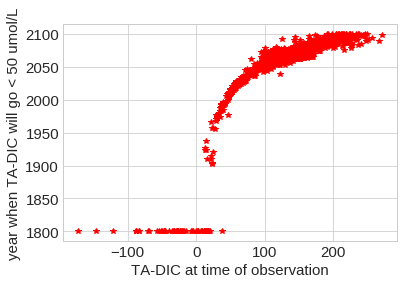

In [147]:
lookup_tableTADIC = np.zeros_like(lookup_table)
for i in range(0, num_obs):
    lookup_tableTADIC[i,:] = tALK_coastal[i] - lookup_table[i,:]

time_of_emergence = np.zeros_like(tALK_coastal)

for i in range(0, len(tALK_coastal)):
    
    close = np.where(lookup_tableTADIC[i,:] <50)
    close = close[0]
    #print(close)
    if len(close) > 0:
        yoe = (np.min(close))
        time_of_emergence[i] = years_record[yoe]
    if len(close) == 0:
        time_of_emergence[i] = np.nan
    #print(np.min(close))
    
    
plt.plot((tALK_coastal-tDIC_coastal),time_of_emergence,'r*')
plt.xlabel('TA-DIC at time of observation')
plt.ylabel('year when TA-DIC will go < 50 umol/L')

#### VISUALISATION OF OBSERVED AGES FROM TTD METHOD - NOTE THAT WHERE CFCS ARE SUPERSATURATED IN WATER COLUMN, AGE == 0. AS HISTOGRAM SHOWS, WE SKEW VERY YOUNG HERE. MAX AGE IS 90. 

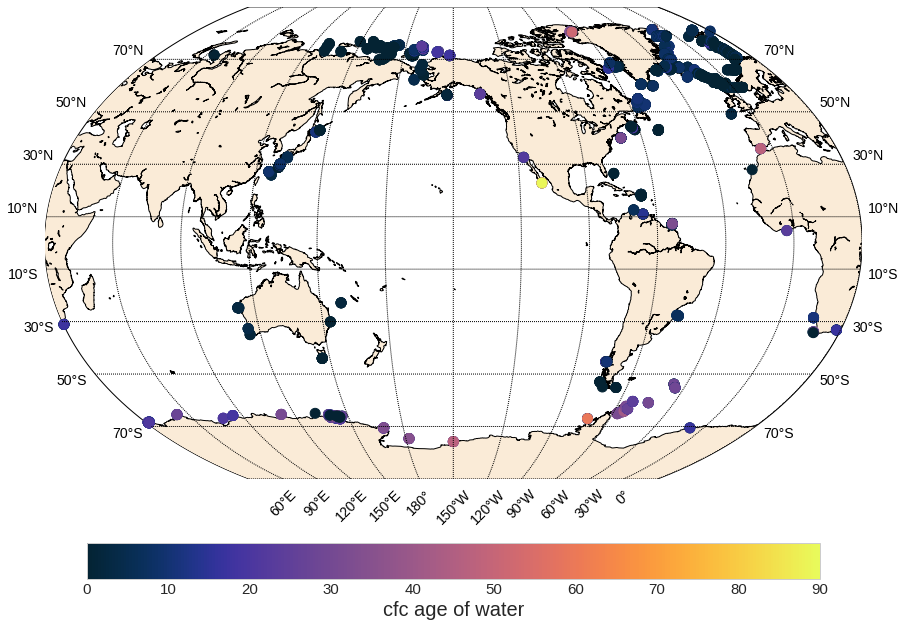

In [148]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
ms = 9
ew = 2.8
ts = 140
fs = 16

# create new figure, axes instances.
# fig=plt.figure()
fact = 2.2
fig = plt.figure(figsize=(6.66*fact, 6.66*fact))

#domain plot - BR run summer average
ax = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

#ax=fig.add_axes([0.1,0.1,3.8,3.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
            rsphere=(6378137.00,6378137.00),\
            resolution='l',projection='kav7',\
            lat_0=40.,lon_0=-150.,lat_ts=20.)

# rsphere=(6378137.00,6356752.3142)

m.drawcoastlines()
m.fillcontinents(color = 'antiquewhite')
# draw parallels
m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1], fontsize = 14)
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], fontsize = 14, rotation = 45)

this_lon = tLON_coastal
this_lat = tLAT_coastal

x,y = m(this_lon, this_lat)
plt.scatter(x, y, c = tAGE_coastal, s  = 100, cmap=cm.cm.thermal,\
        vmin=0, vmax=90, zorder=2)

cbar = plt.colorbar(orientation = 'horizontal',fraction=0.046, pad=0.08)

cbar.set_label(label='cfc age of water', size=fs+4)

plt.show()
plt.show()

bin centre
[ 2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 52.5 57.5 62.5 67.5
 72.5 77.5 82.5 87.5 92.5]
number of observations
[1609  433  171   86   74   46   56   18    7    5    3    2    1    0
    0    0    0    1]


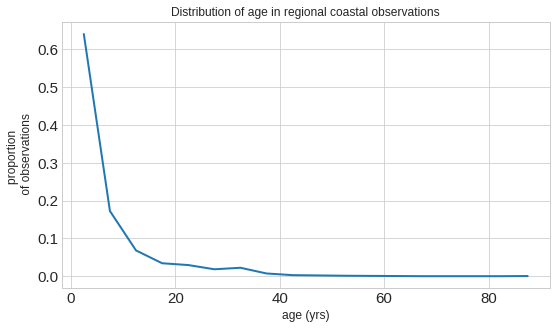

In [149]:
fact = 0.7
fig = plt.figure(figsize=(12.5*fact, 7*fact))
fs = 12
tcol = 'black'
tlw = 4.5
ax6 = plt.subplot(1,1,1)
ax6.set_title('Distribution of age in regional coastal observations', fontsize = fs)
ax6.set_ylabel('proportion \n of observations', fontsize = fs)
ax6.set_xlabel('age (yrs)', fontsize = fs)

#histogram of years:
nbins = 18

w = tAGE_coastal
hist_Omega, bins = np.histogram(w, bins=nbins, range = [0, 90])
#hist_stor[i,:] = hist_Omega
    
bin_cent = bins + (bins[1]-bins[0])/2
print('bin centre')
print(bin_cent)
print('number of observations')
print(hist_Omega)
tot_count = np.sum(hist_Omega)
ax6.plot(bin_cent[0:nbins],hist_Omega/tot_count, lw = 2,)



### QUICK AND DIRTY HIST OF AOU OF THESE COASTAL MEASUREMENTS...

Text(0.5, 0, 'AOU umol/L')

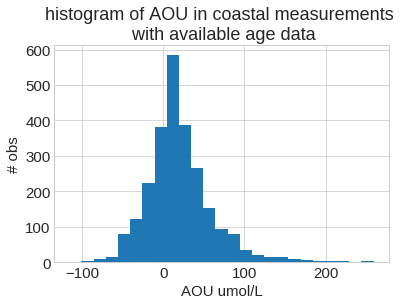

In [150]:
w = plt.hist(tAOU_coastal, bins = 25)
plt.title('histogram of AOU in coastal measurements \n with available age data')
plt.ylabel('# obs')
plt.xlabel('AOU umol/L')

#### DIC AND TA-DIC CONCENTRATION EVOLUTION PLOT FOR WHOLE DATASET

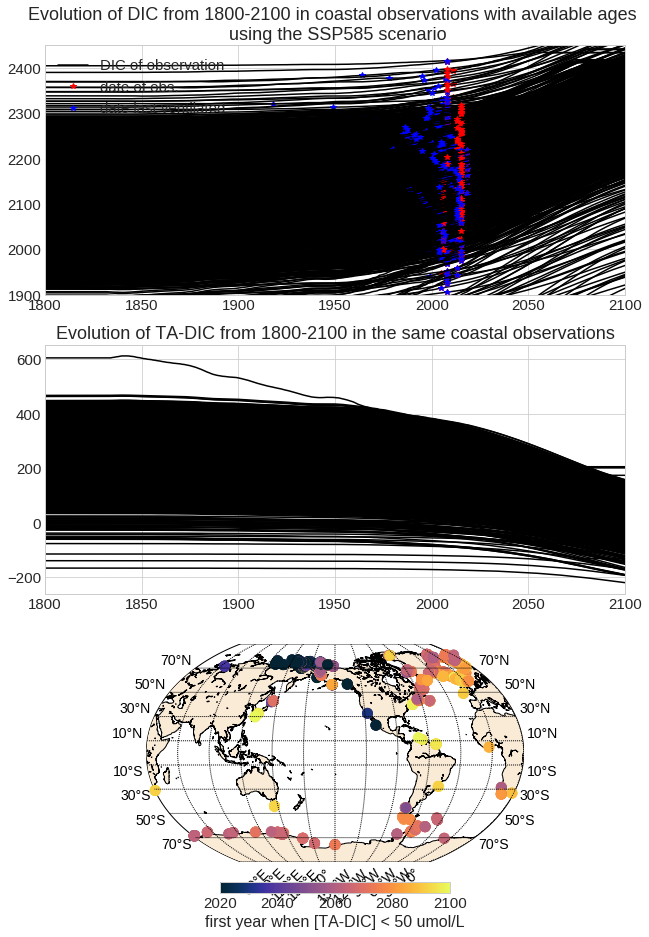

In [151]:


fact = 0.52
fig = plt.figure(figsize=(20*fact,30*fact))
ax1 = fig.add_subplot(3,1,1)
for i in range(0, num_obs):
    ax1.plot(years_record,lookup_table[i,:], 'k-')
    year_obs = tYEAR_coastal[i]
    tyear = np.where(years_record == year_obs)
    tyear = tyear[0][0]
    age_obs = np.int(tAGE_coastal[i])
    
    ax1.plot(years_record[tyear],lookup_table[i,tyear], 'r*')
    ax1.plot(years_record[tyear-age_obs],lookup_table[i,tyear-age_obs], 'b*')
    if i == 1:
        ax1.plot(years_record,lookup_table[i,:], 'k-', label = 'DIC of observation')
        ax1.plot(years_record[tyear],lookup_table[i,tyear], 'r*', label = 'date of obs.') 
        ax1.plot(years_record[tyear-age_obs],lookup_table[i,tyear-age_obs], 'b*',\
                 label = 'date last ventilated')
        ax1.legend(loc = 'best')
ax1.set_xlim([1800,2100])
ax1.set_ylim([1900,2450])
ax1.set_title('Evolution of DIC from 1800-2100 in coastal observations with available ages \n using the SSP585 scenario')

ax1 = fig.add_subplot(3,1,2)
for i in range(0, num_obs):
    TA = tALK_coastal[i]
    TA_DIC = TA - lookup_table[i,:]
    ax1.plot(years_record,TA_DIC, 'k-')
    ax1.set_xlim([1800,2100])
ax1.set_title('Evolution of TA-DIC from 1800-2100 in the same coastal observations')


ax1 = fig.add_subplot(3,1,3)

#ax = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

#ax=fig.add_axes([0.1,0.1,3.8,3.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
            rsphere=(6378137.00,6378137.00),\
            resolution='l',projection='kav7',\
            lat_0=40.,lon_0=-150.,lat_ts=20.)

# rsphere=(6378137.00,6356752.3142)

m.drawcoastlines()
m.fillcontinents(color = 'antiquewhite')
# draw parallels
m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1], fontsize = 14)
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], fontsize = 14, rotation = 45)

this_lon = tLON_coastal
this_lat = tLAT_coastal

x,y = m(this_lon, this_lat)
plt.scatter(x, y, c = time_of_emergence, s  = 100, cmap=cm.cm.thermal,\
        vmin=2020, vmax=2100, zorder=2)

cbar = plt.colorbar(orientation = 'horizontal',fraction=0.046, pad=0.08)

cbar.set_label(label='first year when [TA-DIC] < 50 umol/L', size=fs+4)

#ax1.set_title('Seasonal cycle for atmospheric co2 \n and mean surface pco2 \n (red = BR, blue = PI)')
#ax1.set_ylabel('uatm pco2')



#### regional subsets of the above nearly-illegible plot

In [152]:
list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

In [153]:
def plot_TOES(g):
    list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

    rows = np.where(tGEO == g)

    lookup_subset = lookup_table[rows[0], :]
    lookupTADIC_subset = lookup_tableTADIC[rows[0], :]

    tYEAR_coastal_subset = tYEAR_coastal[tGEO == g]
    tAGE_coastal_subset = tAGE_coastal[tGEO == g]


    fact = 0.52
    fig = plt.figure(figsize=(20*fact,30*fact))
    ax1 = fig.add_subplot(3,1,1)
    for i in range(0, np.size(rows[0])):
        ax1.plot(years_record,lookup_subset[i,:], 'k-')
        year_obs = tYEAR_coastal_subset[i]
        tyear = np.where(years_record == year_obs)
        tyear = tyear[0][0]
        age_obs = np.int(tAGE_coastal_subset[i])

        ax1.plot(years_record[tyear],lookup_subset[i,tyear], 'r*')
        ax1.plot(years_record[tyear-age_obs],lookup_subset[i,tyear-age_obs], 'b*')
        if i == 1:
            ax1.plot(years_record,lookup_subset[i,:], 'k-', label = 'DIC of observation')
            ax1.plot(years_record[tyear],lookup_subset[i,tyear], 'r*', label = 'date of obs.') 
            ax1.plot(years_record[tyear-age_obs],lookup_subset[i,tyear-age_obs], 'b*',\
                     label = 'date last ventilated')
            ax1.legend(loc = 'best')
    ax1.set_xlim([1800,2100])
    ax1.set_ylim([1900,2450])
    ax1.set_title('Evolution of DIC from 1800-2100 in coastal observations with available ages \n using the SSP585 scenario')

    ax1 = fig.add_subplot(3,1,2)
    for i in range(0, np.size(rows[0])):
        #TA_DIC = TA - lookup_table[i,:]
        ax1.plot(years_record,lookupTADIC_subset[i], 'k-')
        ax1.set_xlim([1800,2100])

    plt.axhline(y = 50)
    ax1.set_title('Evolution of TA-DIC from 1800-2100 in the same coastal observations')


    ax1 = fig.add_subplot(3,1,3)

    # setup mercator map projection.
    m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
                rsphere=(6378137.00,6378137.00),\
                resolution='l',projection='kav7',\
                lat_0=40.,lon_0=-150.,lat_ts=20.)

    # rsphere=(6378137.00,6356752.3142)

    m.drawcoastlines()
    m.fillcontinents(color = 'antiquewhite')
    # draw parallels
    m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1], fontsize = 14)
    # draw meridians
    m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], fontsize = 10, rotation = 45)

    this_lon = tLON_coastal[tGEO == g]
    this_lat = tLAT_coastal[tGEO == g]
    TOE_subset = time_of_emergence[tGEO == g]

    x,y = m(this_lon, this_lat)
    plt.scatter(x, y, c = TOE_subset, s  = 100, cmap=cm.cm.thermal,\
            vmin=2020, vmax=2100, zorder=2)

    cbar = plt.colorbar(orientation = 'horizontal',fraction=0.046, pad=0.14)

    cbar.set_label(label='first year when [TA-DIC] < 50 umol/L', size=fs+4)

    #ax1.set_title('Seasonal cycle for atmospheric co2 \n and mean surface pco2 \n (red = BR, blue = PI)')
    #ax1.set_ylabel('uatm pco2')

    plt.suptitle(list_places[g], y = 0.94, fontsize = 20)


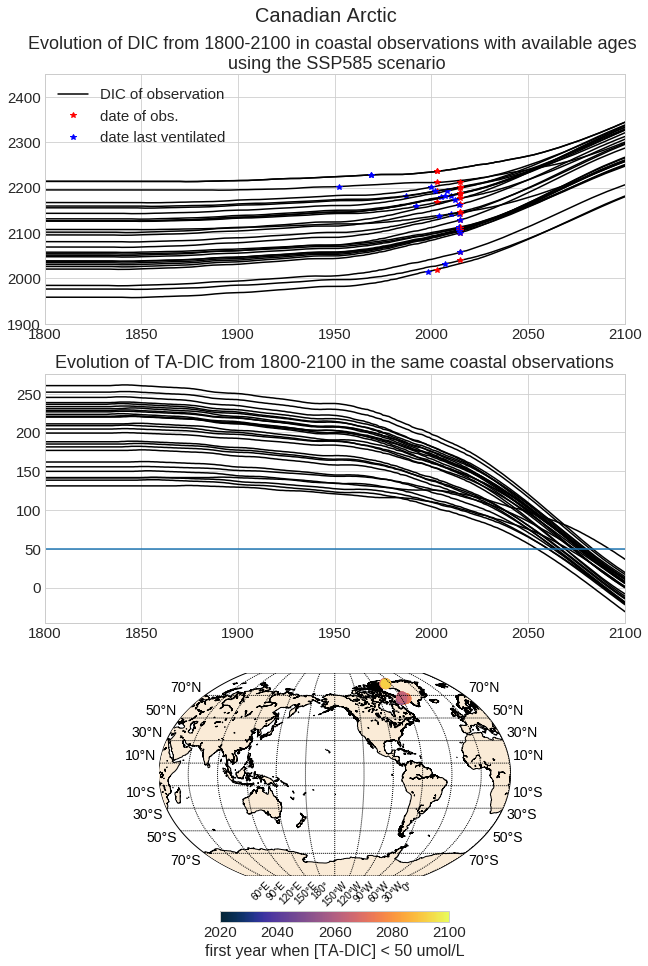

In [154]:
plot_TOES(1)

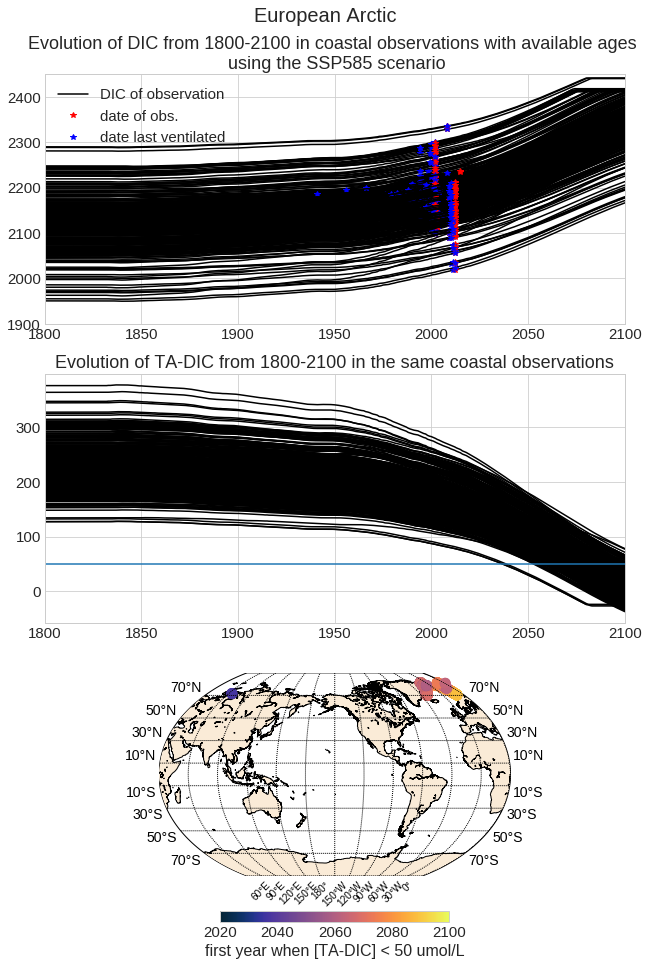

In [155]:
plot_TOES(2)

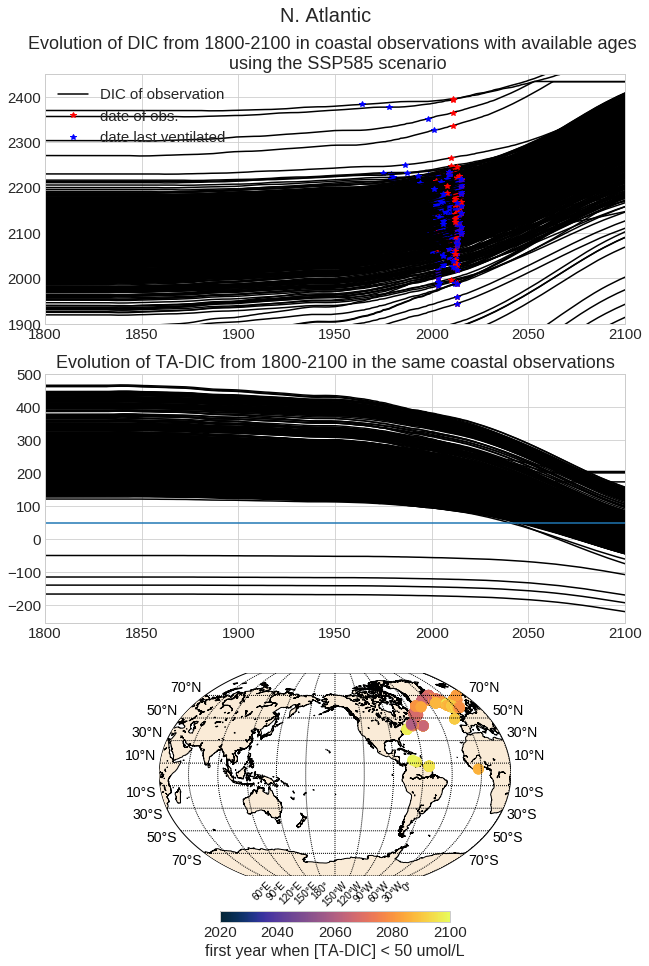

In [156]:
plot_TOES(3)

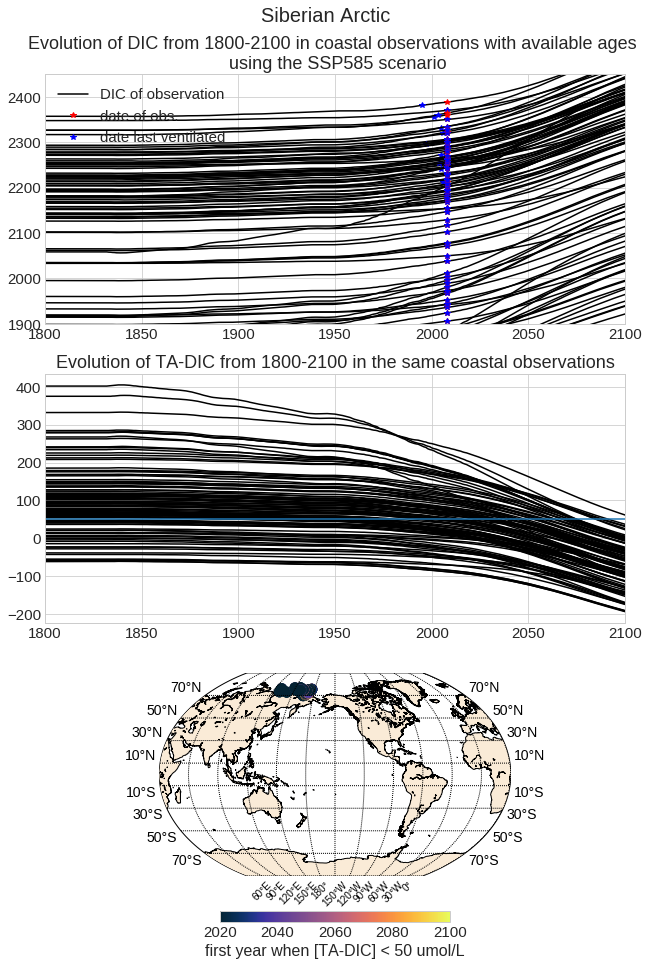

In [157]:
plot_TOES(4)

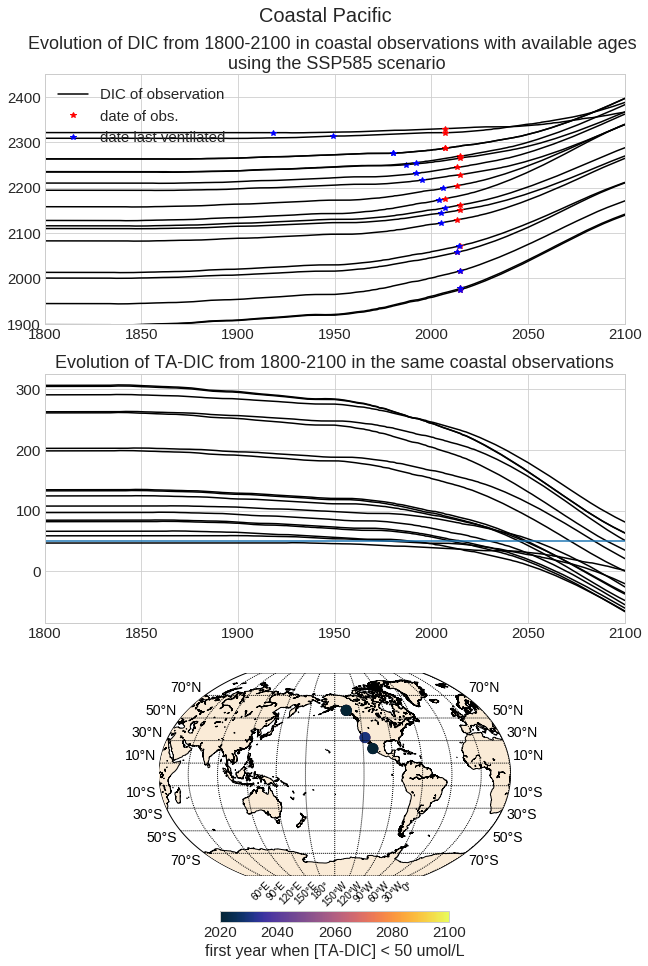

In [158]:
plot_TOES(5)

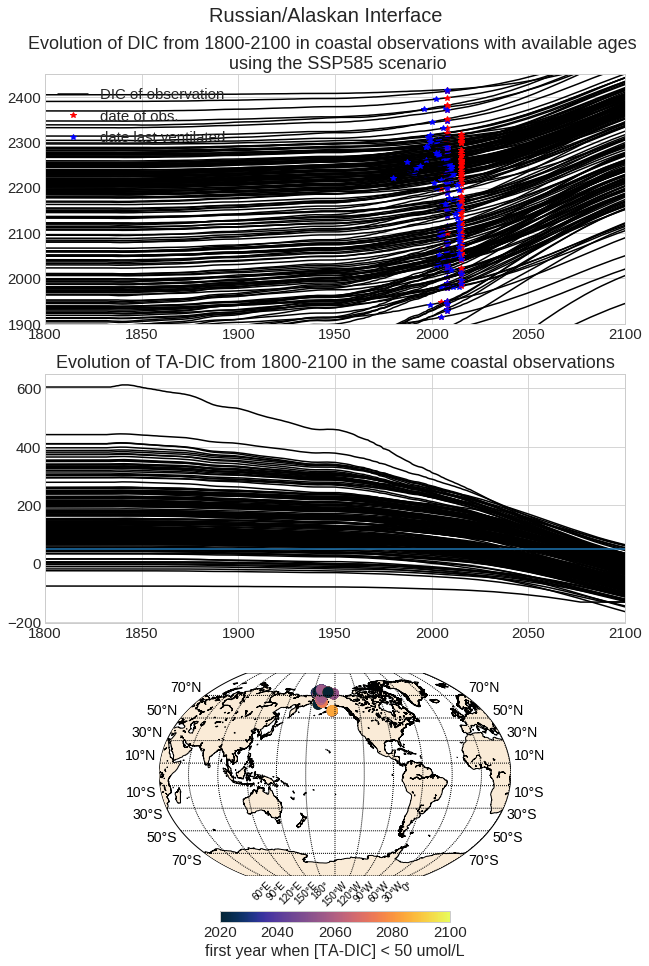

In [159]:
plot_TOES(6)

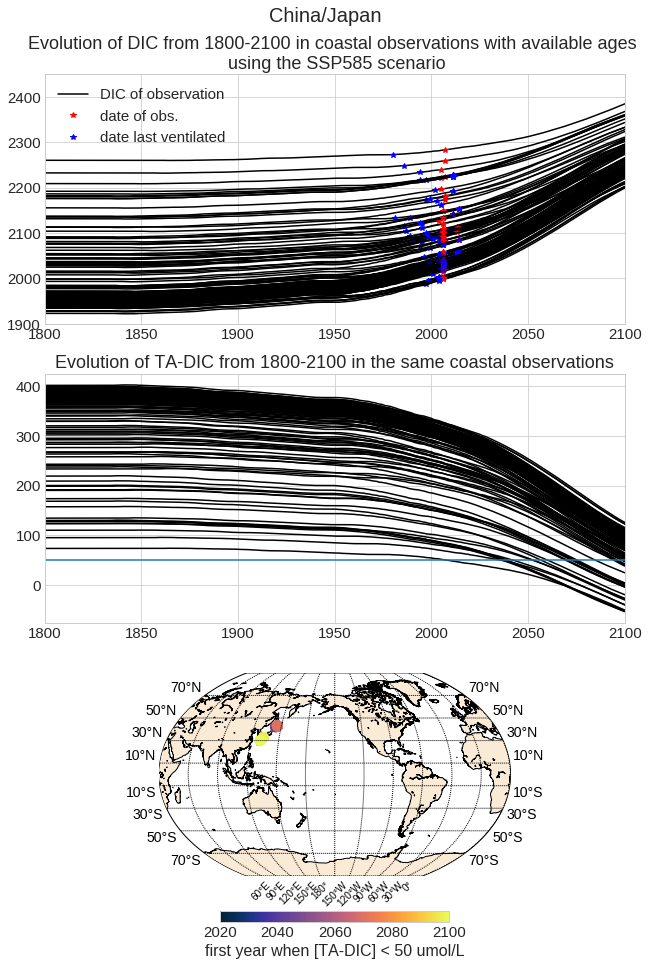

In [161]:
plot_TOES(8)


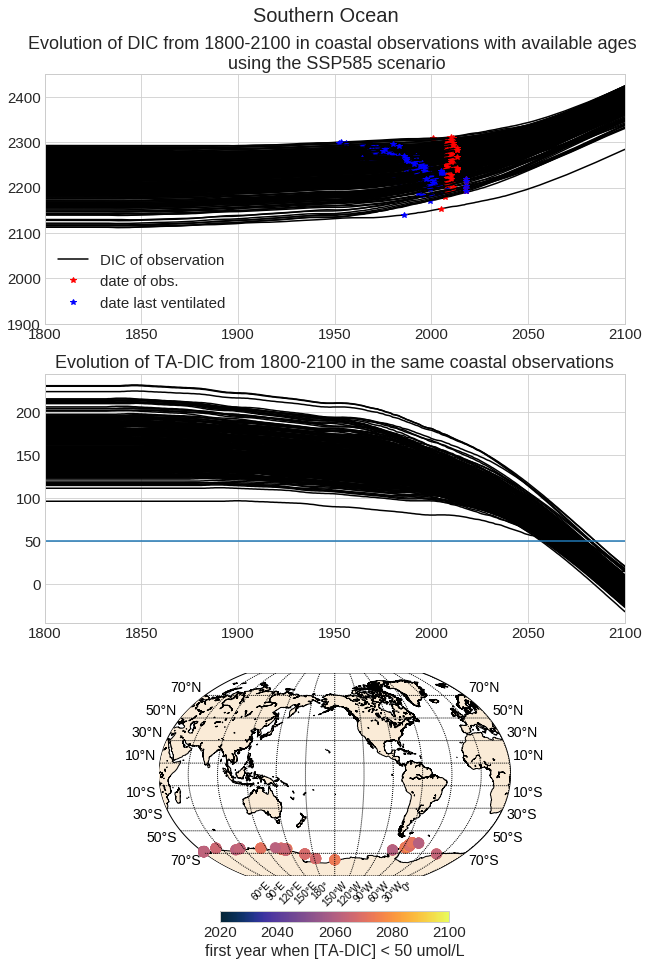

In [162]:
plot_TOES(9)

### A HISTOGRAM OF TIMES OF EMERGENCE OF THIS SIGNAL, BY GEOGRAPHIC SUBREGIONS

In [163]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}



/home/tjarniko/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tjarniko/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


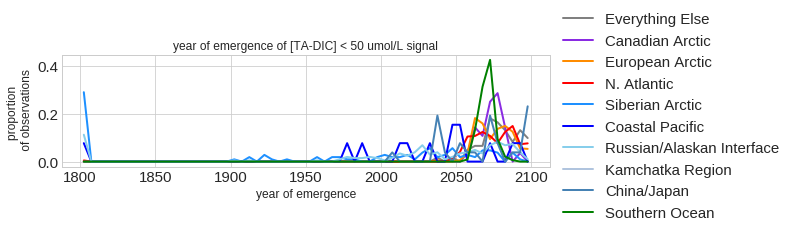

In [164]:
fact = 0.7
fig = plt.figure(figsize=(12.5*fact, 10*fact))
fs = 12
tcol = 'black'
tlw = 4.5
##############################



############################
ax6 = plt.subplot(3,1,1)
ax6.set_title('year of emergence of [TA-DIC] < 50 umol/L signal', fontsize = fs)
ax6.set_ylabel('proportion \n of observations', fontsize = fs)
ax6.set_xlabel('year of emergence', fontsize = fs)

#histogram of omega A:
nbins =60
hist_stor = np.zeros([len(list_places),nbins])

for i in range(0,len(list_places)):
    
    tGEODAT = PLACES_withdat[list_places[i]]['geodat']
    #print(tGEODAT)
    w = time_of_emergence[tGEO == tGEODAT]
   # w = tALK_DIC[filt_comp & (tGEO == i)]
    hist_Omega, bins = np.histogram(w, bins=nbins, range = [1800, 2100])
    hist_stor[i,:] = hist_Omega
    
bin_cent = bins + (bins[1]-bins[0])/2

for i in range(0,len(list_places)):
    tot_count = np.sum(hist_stor[i,:])
    ax6.plot(bin_cent[0:nbins],hist_stor[i,:]/tot_count, \
             color = PLACES_withdat[list_places[i]]['colour'], lw = 2,label = PLACES_withdat[list_places[i]]['name'])

plt.legend(bbox_to_anchor = [1.0, 1.5])
#year_TA_DIC = np.concatenate((summer_TA_DIC_BR3,winter_TA_DIC_BR3),axis=0)
#csize2 = np.concatenate((csize,csize), axis = 0 )
# hist_year_TA_DIC, bins = np.histogram(year_TA_DIC, \
# bins=nbins, range = [-100, 400], weights=csize2)
# bin_cent = bins + (bins[1]-bins[0])/2
# ax6.plot(bin_cent[0:nbins],hist_year_TA_DIC/np.sum(hist_year_TA_DIC),\
#          color = tcol, lw = tlw,label = 'BR - winter mean')


## the same histogram, but looking only at future emergence (TOE < 2020 = np.nan)

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/tjarniko/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tjarniko/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


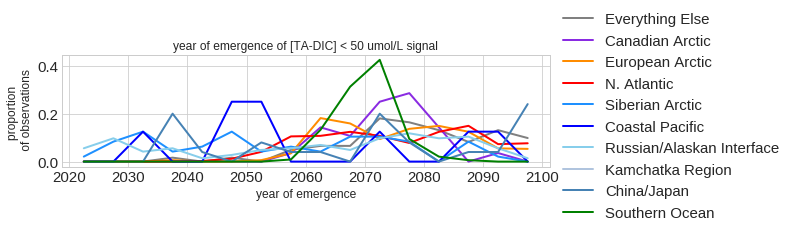

In [165]:
fact = 0.7
fig = plt.figure(figsize=(12.5*fact, 10*fact))
fs = 12
tcol = 'black'
tlw = 4.5
##############################



############################
ax6 = plt.subplot(3,1,1)
ax6.set_title('year of emergence of [TA-DIC] < 50 umol/L signal', fontsize = fs)
ax6.set_ylabel('proportion \n of observations', fontsize = fs)
ax6.set_xlabel('year of emergence', fontsize = fs)

#histogram of omega A:
nbins =16
hist_stor = np.zeros([len(list_places),nbins])

for i in range(0,len(list_places)):
    
    tGEODAT = PLACES_withdat[list_places[i]]['geodat']
    #print(tGEODAT)
    w = time_of_emergence[tGEO == tGEODAT]
    w[w<2020] = np.nan
   # w = tALK_DIC[filt_comp & (tGEO == i)]
    hist_Omega, bins = np.histogram(w, bins=nbins, range = [2020, 2100])
    hist_stor[i,:] = hist_Omega
    
bin_cent = bins + (bins[1]-bins[0])/2

for i in range(0,len(list_places)):
    tot_count = np.sum(hist_stor[i,:])
    ax6.plot(bin_cent[0:nbins],hist_stor[i,:]/tot_count, \
             color = PLACES_withdat[list_places[i]]['colour'], lw = 2,label = PLACES_withdat[list_places[i]]['name'])

plt.legend(bbox_to_anchor = [1.0, 1.5])
#year_TA_DIC = np.concatenate((summer_TA_DIC_BR3,winter_TA_DIC_BR3),axis=0)
#csize2 = np.concatenate((csize,csize), axis = 0 )
# hist_year_TA_DIC, bins = np.histogram(year_TA_DIC, \
# bins=nbins, range = [-100, 400], weights=csize2)
# bin_cent = bins + (bins[1]-bins[0])/2
# ax6.plot(bin_cent[0:nbins],hist_year_TA_DIC/np.sum(hist_year_TA_DIC),\
#          color = tcol, lw = tlw,label = 'BR - winter mean')


### focus on TOE only in north atlantic and S.O. to get mythical "one number"

In [201]:
#na = 3 # so = 9
toe_NA = time_of_emergence[tGEO == 3]
print('mean TOE for observations that have a TOE and are > 2020') 
print(np.nanmean(toe_NA[toe_NA>2020]))
print('% of observations that do not have a TOE (ie TOE > 2100)')
print(np.size(toe_NA[np.isnan(toe_NA)])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2020')
print(np.size(toe_NA[toe_NA<2020])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2050')
print(np.size(toe_NA[toe_NA<2050])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2060')
print(np.size(toe_NA[toe_NA<2060])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2070')
print(np.size(toe_NA[toe_NA<2070])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2080')
print(np.size(toe_NA[toe_NA<2080])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE < 2090')
print(np.size(toe_NA[toe_NA<2090])/np.size(toe_NA)*100)
print('% North Atl. obs with TOE <= 2100')
print(np.size(toe_NA[toe_NA<=2100])/np.size(toe_NA)*100)
print(np.nanmean(toe_NA))

mean TOE for observations that have a TOE and are > 2020
2074.836320191159
% of observations that do not have a TOE (ie TOE > 2100)
17.142857142857142
% North Atl. obs with TOE < 2020
0.3940886699507389
% North Atl. obs with TOE < 2050
1.5763546798029555
% North Atl. obs with TOE < 2060
13.596059113300493
% North Atl. obs with TOE < 2070
32.70935960591133
% North Atl. obs with TOE < 2080
47.98029556650246
% North Atl. obs with TOE < 2090
70.54187192118226
% North Atl. obs with TOE <= 2100
82.85714285714286
2073.529131985731


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

In [192]:
#na = 3 # so = 9
toe_SO = time_of_emergence[tGEO == 9]
print('mean TOE') 
print(np.mean(toe_SO))
#print(np.size)
print('% of observations that do not have a TOE (ie TOE > 2100)')
print(np.size(toe_SO[np.isnan(toe_SO)])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE < 2050')
print(np.size(toe_SO[toe_SO<2050])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE < 2060')
print(np.size(toe_SO[toe_SO<2060])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE < 2070')
print(np.size(toe_SO[toe_SO<2070])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE < 2080')
print(np.size(toe_SO[toe_SO<2080])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE < 2090')
print(np.size(toe_SO[toe_SO<2090])/np.size(toe_SO)*100)
print('% S. Ocean obs with TOE <= 2100')
print(np.size(toe_SO[toe_SO<=2100])/np.size(toe_SO)*100)
print(np.nanmean(toe_SO))

% of observations that do not have a TOE (ie TOE > 2100)
0.0
% S. Ocean obs with TOE < 2050
0.0
% S. Ocean obs with TOE < 2060
0.8849557522123894
% S. Ocean obs with TOE < 2070
45.42772861356932
% S. Ocean obs with TOE < 2080
97.34513274336283
% S. Ocean obs with TOE < 2090
100.0
% S. Ocean obs with TOE <= 2100
100.0
2069.7522123893805
